In [2]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from google.colab import drive
from scipy.sparse import load_npz

# Mount Google Drive
drive.mount('/content/drive')

# Base directory
base_path = Path("/content/drive/MyDrive/")
out_dir = base_path

# Load pre-split datasets
train_df = pd.read_csv(base_path / "train_split.csv")
val_df   = pd.read_csv(base_path / "val_split.csv")
test_df  = pd.read_csv(base_path / "test_split.csv")

# Clean column names
for df in [train_df, val_df, test_df]:
    df.columns = [c.strip() for c in df.columns]

# Load pre-saved TF-IDF matrices
print("Loading pre-saved TF-IDF matrices...")
X_train_tfidf = load_npz(out_dir / "X_train_tfidf.npz")
X_val_tfidf   = load_npz(out_dir / "X_val_tfidf.npz")
X_test_tfidf  = load_npz(out_dir / "X_test_tfidf.npz")

# Labels
y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

# Dataset Overview
summary = {
    "n_train": len(train_df),
    "n_val":   len(val_df),
    "n_test":  len(test_df),
    "n_features": X_train_tfidf.shape[1],
    "train_class_counts": Counter(y_train),
    "val_class_counts":   Counter(y_val),
    "test_class_counts":  Counter(y_test)
}

print("\nSplit summary:")
for k, v in summary.items():
    print(f"{k}: {v}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading pre-saved TF-IDF matrices...

Split summary:
n_train: 8165
n_val: 1167
n_test: 2333
n_features: 51593
train_class_counts: Counter({'positive': 5923, 'negative': 1467, 'neutral': 775})
val_class_counts: Counter({'positive': 847, 'negative': 209, 'neutral': 111})
test_class_counts: Counter({'positive': 1692, 'negative': 419, 'neutral': 222})


🔍 Tuning hyperparameters on the validation set...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters Found:
{'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 2000, 'penalty': 'elasticnet'}

Validation Accuracy: 0.8663
Validation Macro F1-score: 0.6236

Test Accuracy: 0.8646
Test Macro F1-score: 0.6258

Classification Report (Validation):
              precision    recall  f1-score   support

    negative      0.781     0.804     0.792       209
     neutral      0.643     0.081     0.144       111
    positive      0.889     0.985     0.934       847

    accuracy                          0.866      1167
   macro avg      0.771     0.623     0.624      1167
weighted avg      0.846     0.866     0.834      1167


Classification Report (Test):
              precision    recall  f1-score   support

    negative      0.778     0.819     0.798       419
     neutral      0.500     0.086     0.146       222
    positive      0.893     0.978

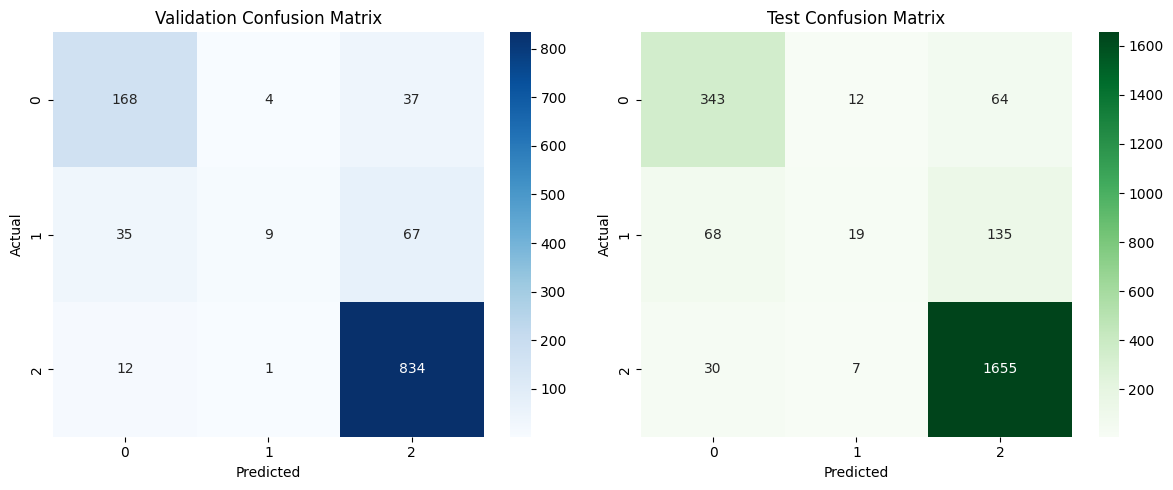

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns

normalizer = Normalizer(copy=False)
X_train_norm = normalizer.fit_transform(X_train_tfidf)
X_val_norm   = normalizer.transform(X_val_tfidf)
X_test_norm  = normalizer.transform(X_test_tfidf)

param_grid = {
    "alpha": [1e-4, 1e-3, 1e-2],
    "penalty": ["l2", "elasticnet"],
    "loss": ["hinge", "modified_huber"],
    "max_iter": [2000],
    "learning_rate": ["optimal"]
}

base_svm = SGDClassifier(random_state=42, tol=1e-3)

grid_search = GridSearchCV(
    base_svm,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("🔍 Tuning hyperparameters on the validation set...")
grid_search.fit(X_train_norm, y_train)

print("\nBest Parameters Found:")
print(grid_search.best_params_)

#Re-train Models
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_norm, y_train)

#Validation Evaluation
y_val_pred = best_svm.predict(X_val_norm)
val_acc = metrics.accuracy_score(y_val, y_val_pred)
val_f1  = metrics.f1_score(y_val, y_val_pred, average='macro')
print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Validation Macro F1-score: {val_f1:.4f}")

#Test Evaluation
y_test_pred = best_svm.predict(X_test_norm)
test_acc = metrics.accuracy_score(y_test, y_test_pred)
test_f1  = metrics.f1_score(y_test, y_test_pred, average='macro')
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Macro F1-score: {test_f1:.4f}")

print("\nClassification Report (Validation):")
print(metrics.classification_report(y_val, y_val_pred, digits=3))

print("\nClassification Report (Test):")
print(metrics.classification_report(y_test, y_test_pred, digits=3))

#Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Validation Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()